In [342]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit, KFold

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.statespace.sarimax import SARIMAX


from sklearn.metrics import mean_squared_error, mean_absolute_error


# Demand Forecast

## Import the data

In [343]:
train_df = pd.read_csv("Data/train.csv")
train_df.head()

,id,date,city,lat,long,pop,shop,brand,container,capacity,price,quantity
0,0.0,31/01/12,Athens,37.97945,23.71622,672130.0,shop_1,kinder-cola,glass,500ml,0.96,13280.0
1,1.0,31/01/12,Athens,37.97945,23.71622,672130.0,shop_1,kinder-cola,plastic,1.5lt,2.86,6727.0
2,2.0,31/01/12,Athens,37.97945,23.71622,672130.0,shop_1,kinder-cola,can,330ml,0.87,9848.0
3,3.0,31/01/12,Athens,37.97945,23.71622,672130.0,shop_1,adult-cola,glass,500ml,1.00,20050.0
4,4.0,31/01/12,Athens,37.97945,23.71622,672130.0,shop_1,adult-cola,can,330ml,0.39,25696.0


In [344]:
df = train_df.copy()

In [345]:
print(df.to_string())

          id      date          city       lat      long       pop    shop         brand container capacity  price  quantity
0        0.0  31/01/12        Athens  37.97945  23.71622  672130.0  shop_1   kinder-cola     glass    500ml   0.96   13280.0
1        1.0  31/01/12        Athens  37.97945  23.71622  672130.0  shop_1   kinder-cola   plastic    1.5lt   2.86    6727.0
2        2.0  31/01/12        Athens  37.97945  23.71622  672130.0  shop_1   kinder-cola       can    330ml   0.87    9848.0
3        3.0  31/01/12        Athens  37.97945  23.71622  672130.0  shop_1    adult-cola     glass    500ml   1.00   20050.0
4        4.0  31/01/12        Athens  37.97945  23.71622  672130.0  shop_1    adult-cola       can    330ml   0.39   25696.0
5        5.0  31/01/12        Athens  37.97945  23.71622  672130.0  shop_1  orange-power     glass    500ml   1.00   15041.0
6        6.0  31/01/12        Athens  37.97945  23.71622  672130.0  shop_1  orange-power       can    330ml   0.43   34578.0


In [346]:
df.shape

(7560, 12)

In [347]:
df.describe()

,id,lat,long,pop,price,quantity
count,6480.000000,6429.000000,6434.000000,6480.000000,6480.000000,6480.000000
mean,3239.500000,38.301238,23.270246,355141.416667,1.188981,29431.855093
std,1870.759204,1.649771,1.086960,232828.796289,0.814567,17901.328301
min,0.000000,35.327870,21.734440,134219.000000,0.110000,2953.000000
25%,1619.750000,37.962450,22.417610,141439.750000,0.610000,16441.750000
50%,3239.500000,38.244440,22.930860,257501.500000,0.920000,25184.000000
75%,4859.250000,39.636890,23.716220,665871.000000,1.500000,37866.000000
max,6479.000000,40.643610,25.143410,672130.000000,4.540000,145287.000000


In [348]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7560 entries, 0 to 7559
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         6480 non-null   float64
 1   date       6480 non-null   object 
 2   city       6480 non-null   object 
 3   lat        6429 non-null   float64
 4   long       6434 non-null   float64
 5   pop        6480 non-null   float64
 6   shop       6480 non-null   object 
 7   brand      6480 non-null   object 
 8   container  6464 non-null   object 
 9   capacity   6465 non-null   object 
 10  price      6480 non-null   float64
 11  quantity   6480 non-null   float64
dtypes: float64(6), object(6)
memory usage: 708.9+ KB


In [349]:
df.tail()

,id,date,city,lat,long,pop,shop,brand,container,capacity,price,quantity
7555,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7557,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7558,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7559,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There are many missing data after 6479 row. Drop the data after 6479 row.

In [350]:
# All values after row 6479 are NaN.
df  = df.drop(df.index[6480:])
df.tail()

,id,date,city,lat,long,pop,shop,brand,container,capacity,price,quantity
6475,6475.0,31/12/17,Athens,37.96245,23.68708,665871.0,shop_3,orange-power,plastic,1.5lt,1.02,33201.0
6476,6476.0,31/12/17,Larisa,39.63689,22.41761,144302.0,shop_5,orange-power,can,330ml,0.47,46971.0
6477,6477.0,31/12/17,Patra,38.24444,21.73444,168501.0,shop_6,adult-cola,glass,500ml,1.02,47708.0
6478,6478.0,31/12/17,Thessaloniki,40.64361,22.93086,353001.0,shop_4,gazoza,plastic,1.5lt,1.34,27115.0
6479,6479.0,31/12/17,Thessaloniki,40.64361,22.93086,353001.0,shop_4,adult-cola,glass,500ml,1.16,30413.0


In [351]:
df.shape

(6480, 12)

### Check missing data percentage

In [352]:
def missing_percentage(df):
        
    total = df.isnull().sum().sort_values(ascending=False)[df.isnull().sum().sort_values(ascending=False) != 0]
    percent = (df.isnull().sum().sort_values(ascending=False) / len(df) * 100)[(df.isnull().sum().sort_values(ascending=False) / len(df) *100) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [353]:
missing = missing_percentage(df)
missing

,Total,Percent
lat,51,0.787037
long,46,0.709877
container,16,0.246914
capacity,15,0.231481


Less than 1% data is missing.

## EDA

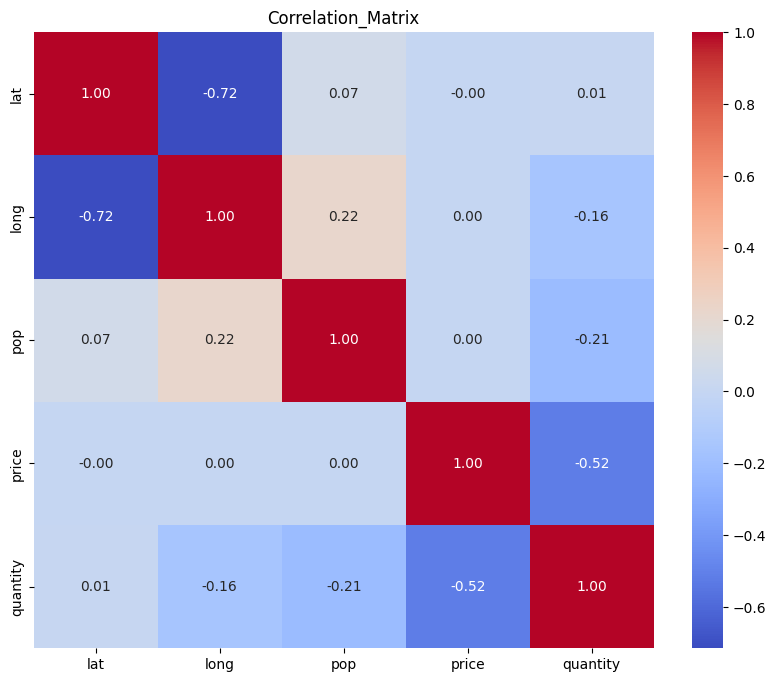

In [354]:
# Check for correlation
correlation_matrix = df[['lat','long','pop','price','quantity']].corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix,annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation_Matrix")
plt.show()

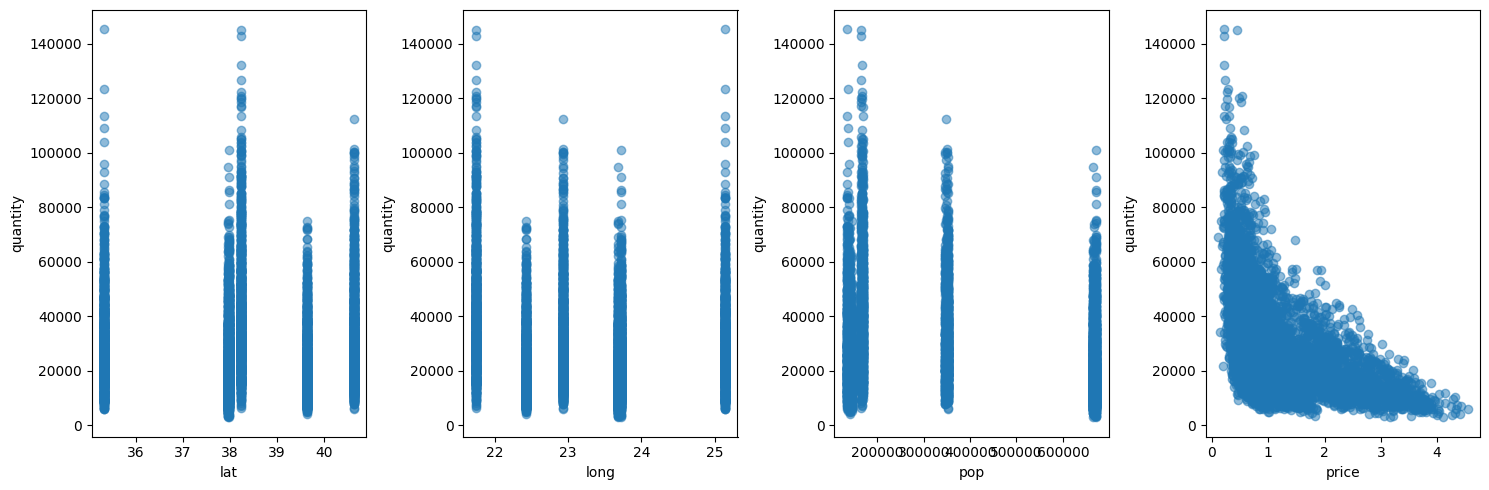

In [355]:
# check the distribution of the features
features = ['lat','long','pop','price']
fig, axes = plt.subplots(nrows=1, ncols= len(features), figsize=(15, 5))

# Plot scatter plots
for i, feature in enumerate(features):
    axes[i].scatter(df[feature], df['quantity'], alpha=0.5)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('quantity')

plt.tight_layout()
plt.show()

- lat and long are the position of the 5 shops. There is high correlation between 'lat' and 'long' and also both of these feature not seems to be useful.
- pop is the population of the cities

### understanding different shops, brands and sales

In [356]:
# Summary Stats for each shop
df.groupby(["shop"]).agg({"quantity": ["count","sum", "mean", "median", "std", "min", "max"]})

quantity                                                           \
          count         sum          mean   median           std     min   
shop                                                                       
shop_1     1080  27848377.0  25785.534259  22430.5  14212.281811  2953.0   
shop_2     1080  33347704.0  30877.503704  27343.5  16787.954095  5875.0   
shop_3     1080  22275589.0  20625.545370  17828.0  12138.668568  3010.0   
shop_4     1080  36490925.0  33787.893519  29923.0  18055.794936  6184.0   
shop_5     1080  25462710.0  23576.583333  20210.5  12921.563541  4293.0   
shop_6     1080  45293116.0  41938.070370  37105.0  22297.944892  6510.0   

                  
             max  
shop              
shop_1  100994.0  
shop_2  145287.0  
shop_3   94777.0  
shop_4  112253.0  
shop_5   75069.0  
shop_6  144973.0

In [357]:
# Summary Stats for each shop
df.groupby(["shop","brand"]).agg({"quantity": ["count","sum", "mean", "median", "std", "min", "max"]})

quantity                                                   \
                       count         sum          mean   median           std   
shop   brand                                                                    
shop_1 adult-cola        216   4931693.0  22831.912037  20705.5   9909.834121   
       gazoza            216   8317177.0  38505.449074  36871.5  15389.710093   
       kinder-cola       216   3136043.0  14518.717593  13275.5   5913.894892   
       lemon-boost       216   4523385.0  20941.597222  19086.0   9007.632564   
       orange-power      216   6940079.0  32129.995370  29896.5  14131.031016   
shop_2 adult-cola        216   5863808.0  27147.259259  25692.5  10842.932612   
       gazoza            216  10150096.0  46991.185185  44125.0  18711.974655   
       kinder-cola       216   3760156.0  17408.129630  16607.0   6697.243644   
       lemon-boost       216   5398608.0  24993.555556  24281.5  10038.217321   
       orange-power      216   8175036.0  37847.388889  35450.0  16136.962382   
shop_3 adult-cola        216   4023123.0  18625.569444  16959.0   8813.755993   
       gazoza            216   6600782.0  30559.175926  29020.0  13822.953357   
       kinder-cola       216   2454571.0  11363.754630  10341.0   5053.075267   
       lemon-boost       216   3604121.0  16685.745370  16136.5   7310.613748   
       orange-power      216   5592992.0  25893.481481  22856.0  12606.905255   
shop_4 adult-cola        216   6598948.0  30550.685185  29768.0  12403.537451   
       gazoza            216  11001723.0  50933.902778  48515.5  20260.874899   
       kinder-cola       216   3974655.0  18401.180556  17716.5   6740.534749   
       lemon-boost       216   5934341.0  27473.800926  26394.5  10584.465915   
       orange-power      216   8981258.0  41579.898148  39087.0  16417.160746   
shop_5 adult-cola        216   4607451.0  21330.791667  19309.5  10205.599361   
       gazoza            216   7429672.0  34396.629630  32974.0  12920.669322   
       kinder-cola       216   2815321.0  13033.893519  12441.5   5049.789889   
       lemon-boost       216   4157186.0  19246.231481  17840.5   8258.040095   
       orange-power      216   6453080.0  29875.370370  27944.5  13420.065575   
shop_6 adult-cola        216   8080987.0  37411.976852  35886.0  15308.076615   
       gazoza            216  13850934.0  64124.694444  60227.5  24321.245317   
       kinder-cola       216   5144506.0  23817.157407  22884.0   9419.092794   
       lemon-boost       216   7289566.0  33747.990741  31433.0  13312.858318   
       orange-power      216  10927123.0  50588.532407  46056.0  20392.423190   

                                        
                         min       max  
shop   brand                            
shop_1 adult-cola     3642.0   68189.0  
       gazoza         7113.0  100994.0  
       kinder-cola    3841.0   38098.0  
       lemon-boost    2953.0   56011.0  
       orange-power   5777.0   81123.0  
shop_2 adult-cola     7753.0   55555.0  
       gazoza        17259.0  145287.0  
       kinder-cola    6082.0   42805.0  
       lemon-boost    5875.0   67979.0  
       orange-power   6435.0  103792.0  
shop_3 adult-cola     4623.0   58567.0  
       gazoza         7321.0   74902.0  
       kinder-cola    3010.0   30153.0  
       lemon-boost    3301.0   44192.0  
       orange-power   5692.0   94777.0  
shop_4 adult-cola     9196.0   76785.0  
       gazoza         9974.0  112253.0  
       kinder-cola    6184.0   39611.0  
       lemon-boost    7975.0   64285.0  
       orange-power  11909.0   99834.0  
shop_5 adult-cola     4727.0   75069.0  
       gazoza         7516.0   72641.0  
       kinder-cola    4293.0   30001.0  
       lemon-boost    5271.0   51169.0  
       orange-power   6321.0   72218.0  
shop_6 adult-cola     6510.0   97326.0  
       gazoza        15292.0  144973.0  
       kinder-cola    7176.0   58792.0  
       lemon-boost    9722.0   78063.0  
       orange-power  16065.0  1320

### Sales distribution

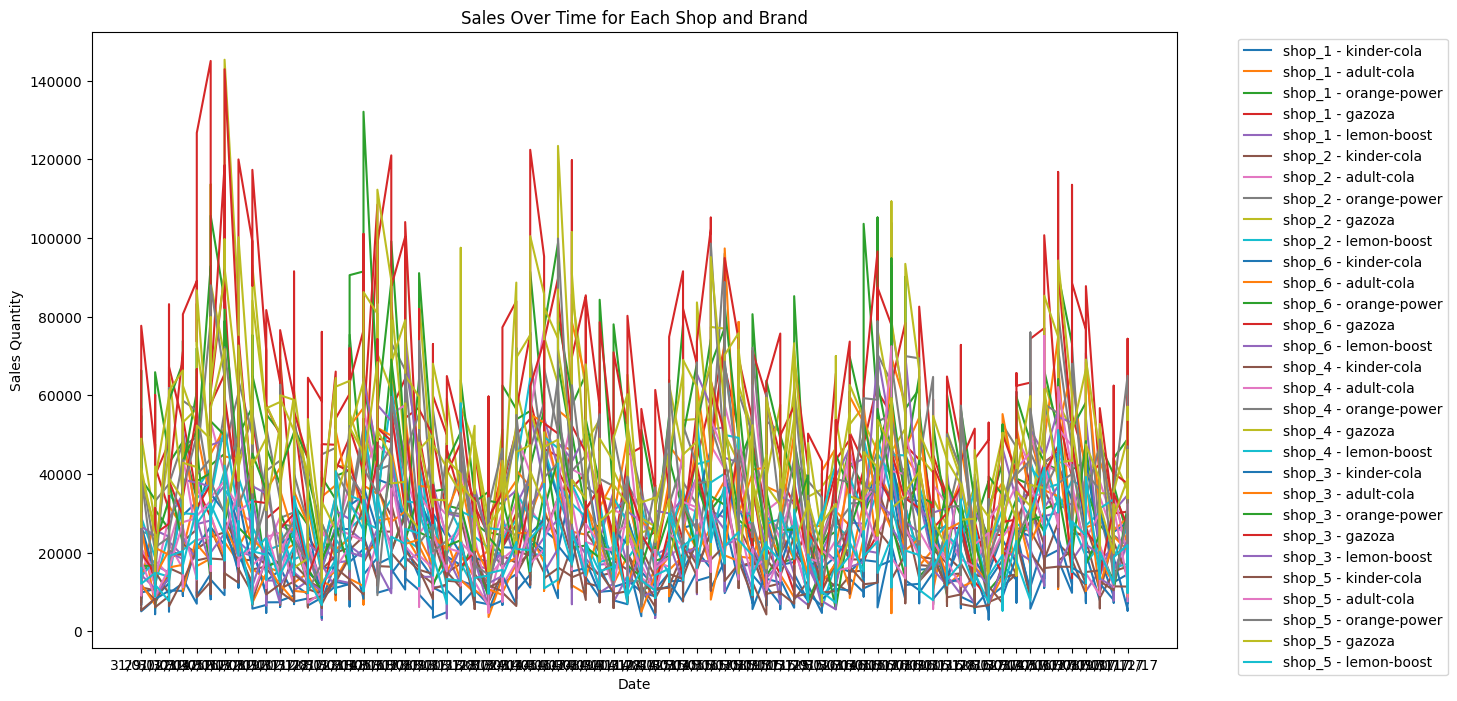

In [358]:
plt.figure(figsize=(14, 8))

for shop in df['shop'].unique():
    for brand in df['brand'].unique():
        subset = df[(df['shop'] == shop) & (df['brand'] == brand)]
        plt.plot(subset['date'], subset['quantity'], label=f'{shop} - {brand}')

plt.title('Sales Over Time for Each Shop and Brand')
plt.xlabel('Date')
plt.ylabel('Sales Quantity')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position
plt.show()

### Shop and brand wise sales distribution

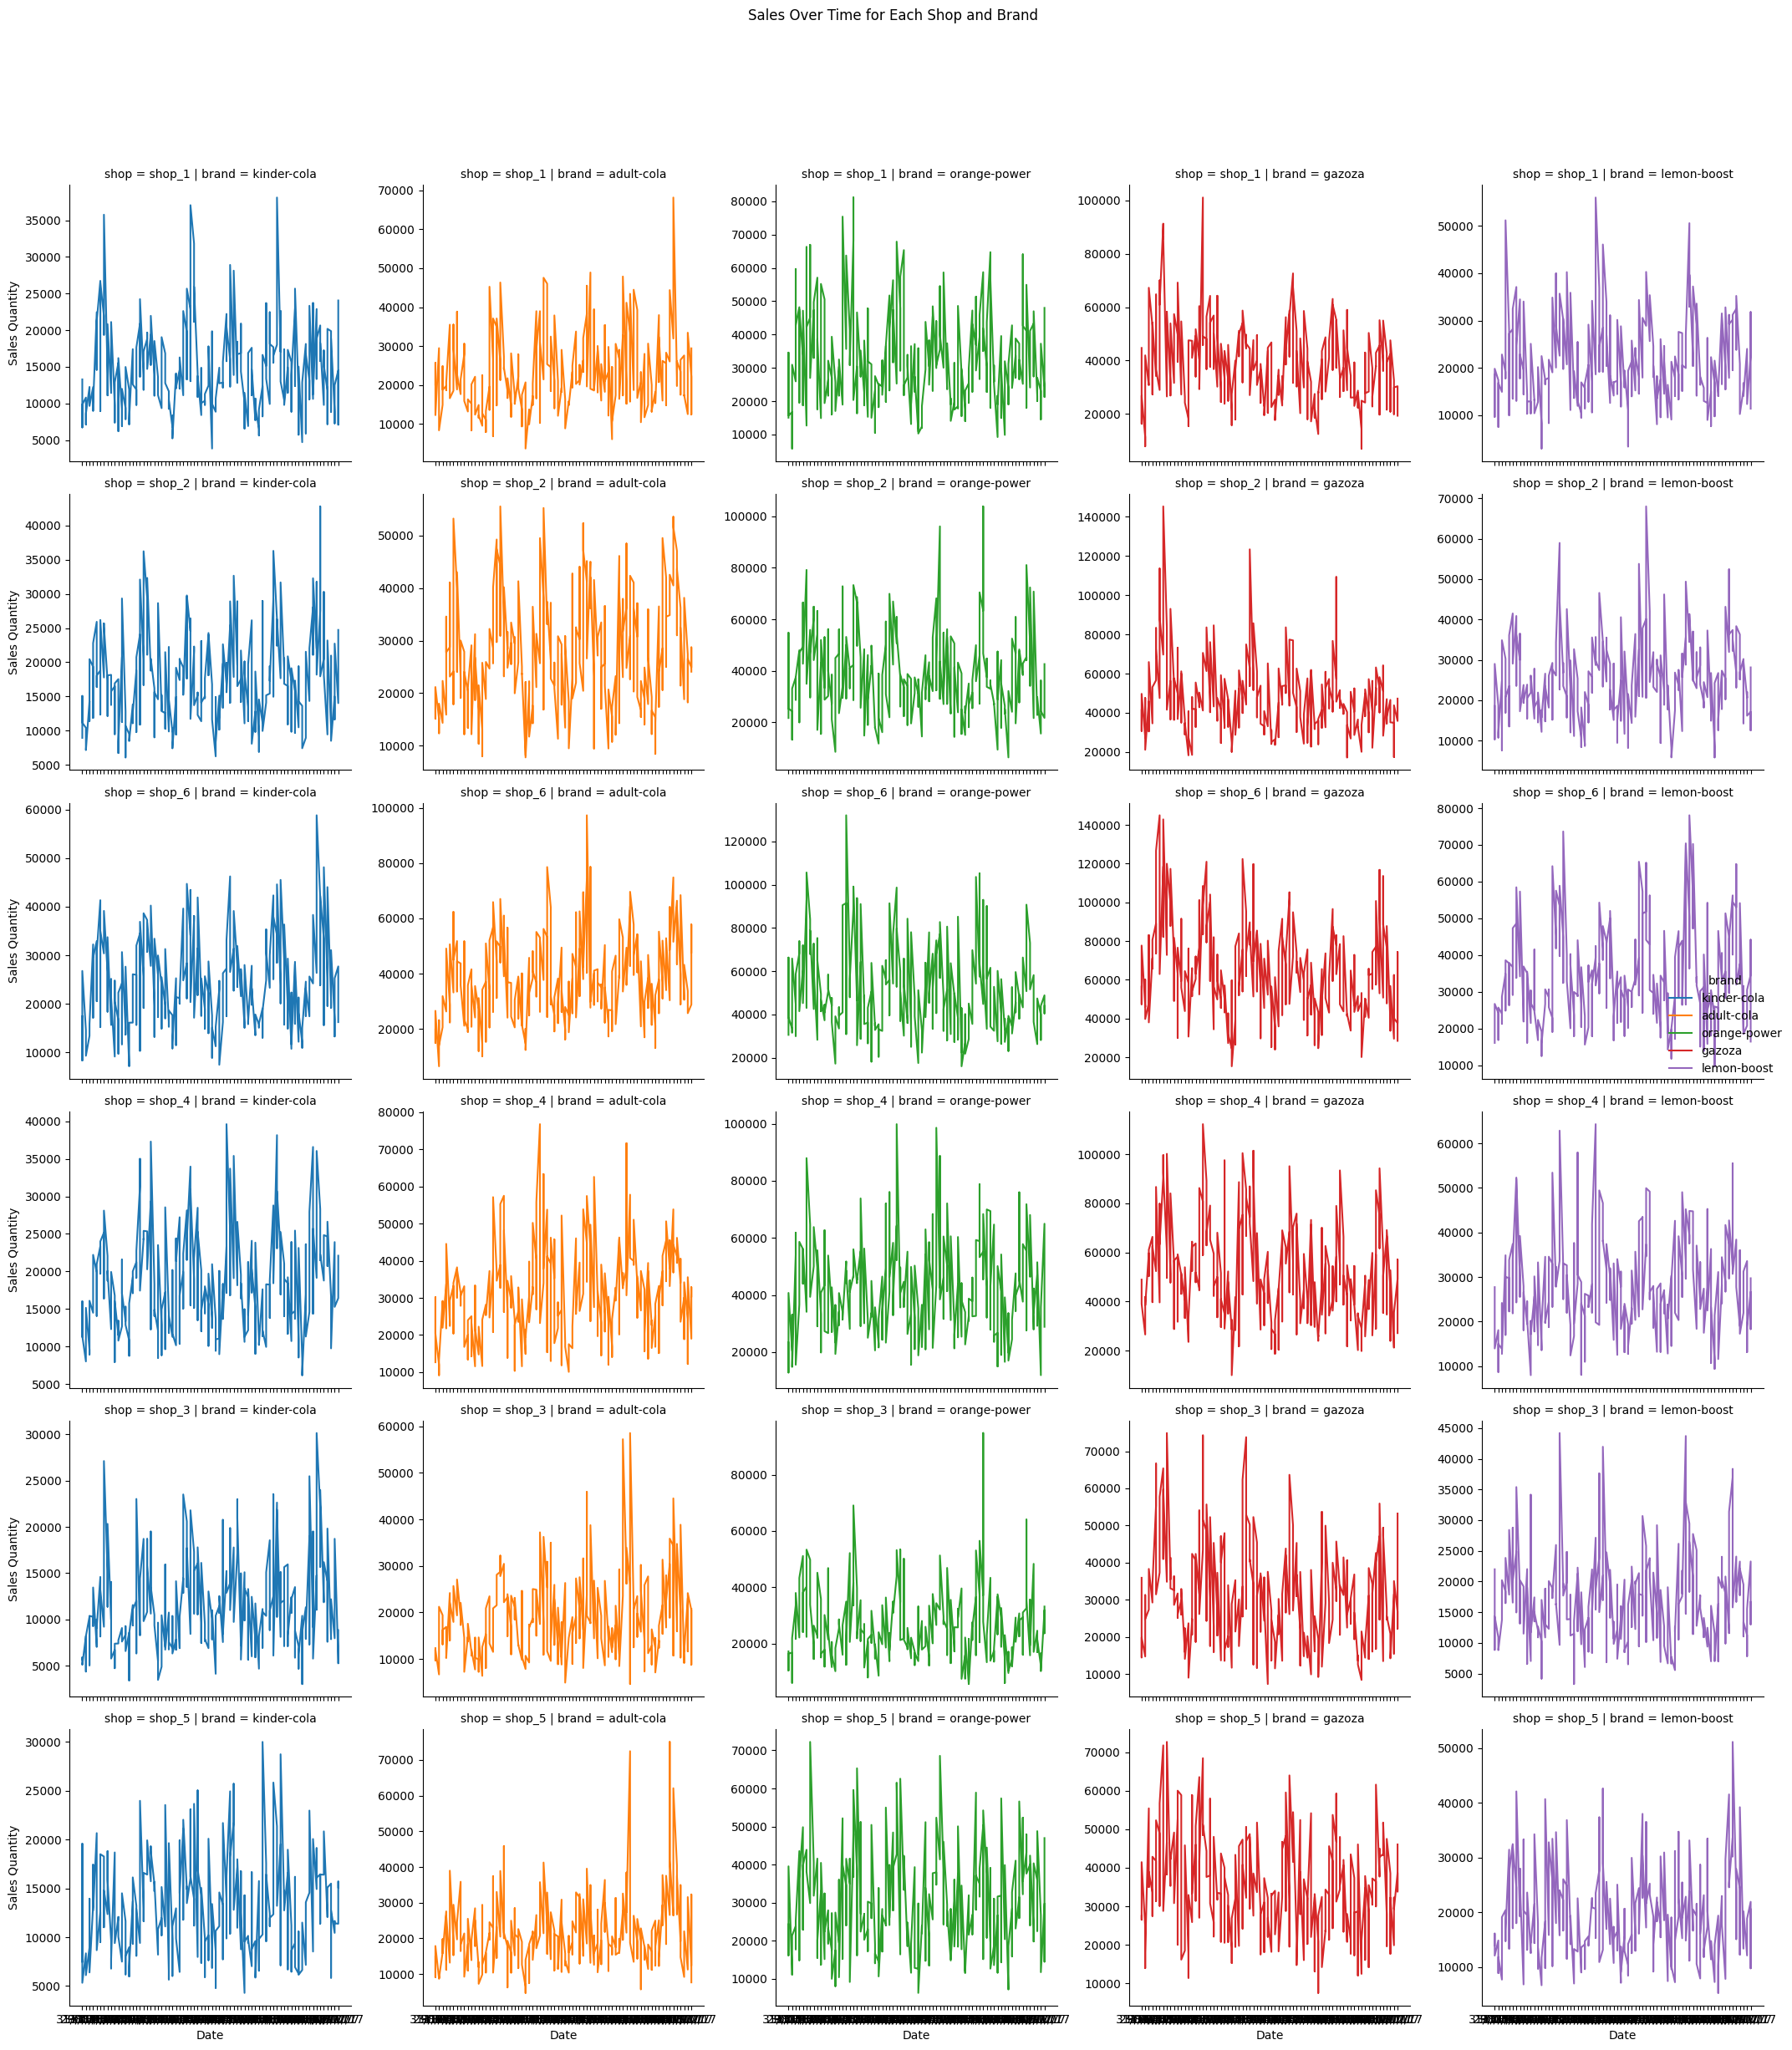

In [359]:
g = sns.FacetGrid(df, col="brand", row="shop", hue="brand", sharey=False, height=4)
g.map(plt.plot, "date", "quantity").add_legend()

g.fig.suptitle('Sales Over Time for Each Shop and Brand', y=1.02)
g.set_axis_labels('Date', 'Sales Quantity')

g.tight_layout(rect=[0, 0, 1, 0.96])

plt.show()

In [361]:
df.groupby(['lat','long','shop'],as_index=False)['id'].count()

,lat,long,shop,id
0,35.32787,25.14341,shop_2,1065
1,37.96245,23.68708,shop_3,1064
2,37.97945,23.71622,shop_1,1069
3,38.24444,21.73444,shop_6,1071
4,39.63689,22.41761,shop_5,1067
5,40.64361,22.93086,shop_4,1071


- Lattitude and longitude of each shop. we can drop these two column

In [362]:
# Check number of unique cities
print(f'Number of unique cities: {df["city"].nunique()}')
df["city"].value_counts().sort_values(ascending=False)

Number of unique cities: 5


city
Athens          2160
Irakleion       1080
Patra           1080
Thessaloniki    1080
Larisa          1080
Name: count, dtype: int64

- There are 5 cities data

In [364]:
# Check number of unique containers
print(f'Number of unique cities: {df["container"].nunique()}')
df["container"].value_counts().sort_values(ascending=False)

Number of unique cities: 3


container
plastic    2157
glass      2154
can        2153
Name: count, dtype: int64

In [365]:
# Check number of unique capacity
print(f'Number of unique cities: {df["capacity"].nunique()}')
df["capacity"].value_counts().sort_values(ascending=False)

Number of unique cities: 3


capacity
1.5lt    2157
330ml    2156
500ml    2152
Name: count, dtype: int64

- There are 3 containers and 3 different capacity

In [366]:
pd.DataFrame(df.groupby(['shop','brand','container'],as_index=False)['id'].count())

,shop,brand,container,id
0,shop_1,adult-cola,can,72
1,shop_1,adult-cola,glass,72
2,shop_1,adult-cola,plastic,72
3,shop_1,gazoza,can,72
4,shop_1,gazoza,glass,72
...,...,...,...,...
85,shop_6,lemon-boost,glass,72
86,shop_6,lemon-boost,plastic,71
87,shop_6,orange-power,can,72
88,shop_6,orange-power,glass,71


In [367]:
df.groupby(['container','capacity'],as_index=False)['id'].count()

,container,capacity,id
0,can,330ml,2149
1,glass,500ml,2146
2,plastic,1.5lt,2154


- Here we can see that container and capacity is related. Hence we can keep any one of the feature.

In [368]:
con_missing = df[df['container'].isnull() | df['capacity'].isnull()]
con_missing

,id,date,city,lat,long,pop,shop,brand,container,capacity,price,quantity
16,16.0,31/01/12,Irakleion,35.32787,25.14341,134219.0,shop_2,orange-power,NaN,330ml,0.23,54780.0
577,577.0,31/07/12,Patra,38.24444,21.73444,164250.0,shop_6,lemon-boost,NaN,1.5lt,2.16,33800.0
740,740.0,30/09/12,Irakleion,35.32787,25.14341,134219.0,shop_2,orange-power,NaN,500ml,0.64,54164.0
1051,1051.0,31/12/12,Larisa,39.63689,22.41761,137540.0,shop_5,kinder-cola,NaN,500ml,1.40,7497.0
1553,1553.0,30/06/13,Patra,38.24444,21.73444,166301.0,shop_6,kinder-cola,glass,NaN,1.46,25634.0
1694,1694.0,31/07/13,Larisa,39.63689,22.41761,139242.0,shop_5,gazoza,NaN,330ml,0.36,37603.0
1847,1847.0,30/09/13,Thessaloniki,40.64361,22.93086,347001.0,shop_4,gazoza,plastic,NaN,0.93,42320.0
2584,2584.0,31/05/14,Athens,37.96245,23.68708,668203.0,shop_3,lemon-boost,glass,NaN,0.61,27136.0
3040,3040.0,31/10/14,Larisa,39.63689,22.41761,140563.0,shop_5,adult-cola,can,NaN,0.69,21225.0
3246,3246.0,31/01/15,Athens,37.97945,23.71622,667237.0,shop_1,gazoza,glass,NaN,0.51,46809.0


- We can replace missing values in container with the help of capacity data and viceversa

## Data Preprocessing

In [369]:
def onehot_encode(df, column):
    df = df.copy()
    dummies = pd.get_dummies(df[column], prefix=column)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1)
    return df

def encode_dates(df, column):
    df = df.copy()
    df[column] = pd.to_datetime(df[column])
    df[column + '_year'] = df[column].apply(lambda x: x.year)
    df[column + '_month'] = df[column].apply(lambda x: x.month)
    df[column + '_day'] = df[column].apply(lambda x: x.day)
    df = df.drop(column, axis=1)
    return df

In [370]:
def preprocess_inputs(df):
    df = df.copy()

    # filling nan in capacity
    condition_1 = (df['capacity'] == '330ml') & (df['container'].isnull())
    condition_2 = (df['capacity'] == '500ml') & (df['container'].isnull())
    condition_3 = (df['capacity'] == '1.5lt') & (df['container'].isnull())

    # Replace values based on conditions
    df.loc[condition_1, 'container'] = 'can'
    df.loc[condition_2, 'container'] = 'glass'
    df.loc[condition_3, 'container'] = 'plastic'
    
    # Drop id, lat, long column
    df = df.drop(['id', 'lat', 'long','capacity'], axis=1)

    # One-hot encode nominal features
    for column in ['city', 'shop', 'brand', 'container']:
        df = onehot_encode(df, column=column)
    
    # Extract date features
    #df = encode_dates(df, column='date')
    
    # Split df into X and y
    #y = df['quantity']
    #X = df.drop('quantity', axis=1)
    
    return df

In [371]:
df = preprocess_inputs(df)
df

,date,pop,price,quantity,city_Athens,city_Irakleion,city_Larisa,city_Patra,city_Thessaloniki,shop_shop_1,...,shop_shop_5,shop_shop_6,brand_adult-cola,brand_gazoza,brand_kinder-cola,brand_lemon-boost,brand_orange-power,container_can,container_glass,container_plastic
0,31/01/12,672130.0,0.96,13280.0,True,False,False,False,False,True,...,False,False,False,False,True,False,False,False,True,False
1,31/01/12,672130.0,2.86,6727.0,True,False,False,False,False,True,...,False,False,False,False,True,False,False,False,False,True
2,31/01/12,672130.0,0.87,9848.0,True,False,False,False,False,True,...,False,False,False,False,True,False,False,True,False,False
3,31/01/12,672130.0,1.00,20050.0,True,False,False,False,False,True,...,False,False,True,False,False,False,False,False,True,False
4,31/01/12,672130.0,0.39,25696.0,True,False,False,False,False,True,...,False,False,True,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6475,31/12/17,665871.0,1.02,33201.0,True,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True
6476,31/12/17,144302.0,0.47,46971.0,False,False,True,False,False,False,...,True,False,False,False,False,False,True,True,False,False
6477,31/12/17,168501.0,1.02,47708.0,False,False,False,True,False,False,...,False,True,True,False,False,False,False,False,True,False
6478,31/12/17,353001.0,1.34,27115.0,False,False,False,False,True,False,...,False,False,False,True,False,False,False,False,False,True


In [372]:
df.columns

Index(['date', 'pop', 'price', 'quantity', 'city_Athens', 'city_Irakleion',
       'city_Larisa', 'city_Patra', 'city_Thessaloniki', 'shop_shop_1',
       'shop_shop_2', 'shop_shop_3', 'shop_shop_4', 'shop_shop_5',
       'shop_shop_6', 'brand_adult-cola', 'brand_gazoza', 'brand_kinder-cola',
       'brand_lemon-boost', 'brand_orange-power', 'container_can',
       'container_glass', 'container_plastic'],
      dtype='object')

In [373]:
boolean_columns = ['city_Athens', 'city_Irakleion',
       'city_Larisa', 'city_Patra', 'city_Thessaloniki', 'shop_shop_1',
       'shop_shop_2', 'shop_shop_3', 'shop_shop_4', 'shop_shop_5',
       'shop_shop_6', 'brand_adult-cola', 'brand_gazoza', 'brand_kinder-cola',
       'brand_lemon-boost', 'brand_orange-power', 'container_can',
       'container_glass', 'container_plastic']

df[boolean_columns] = df[boolean_columns].astype(int)
df


,date,pop,price,quantity,city_Athens,city_Irakleion,city_Larisa,city_Patra,city_Thessaloniki,shop_shop_1,...,shop_shop_5,shop_shop_6,brand_adult-cola,brand_gazoza,brand_kinder-cola,brand_lemon-boost,brand_orange-power,container_can,container_glass,container_plastic
0,31/01/12,672130.0,0.96,13280.0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0
1,31/01/12,672130.0,2.86,6727.0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
2,31/01/12,672130.0,0.87,9848.0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0
3,31/01/12,672130.0,1.00,20050.0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
4,31/01/12,672130.0,0.39,25696.0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6475,31/12/17,665871.0,1.02,33201.0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
6476,31/12/17,144302.0,0.47,46971.0,0,0,1,0,0,0,...,1,0,0,0,0,0,1,1,0,0
6477,31/12/17,168501.0,1.02,47708.0,0,0,0,1,0,0,...,0,1,1,0,0,0,0,0,1,0
6478,31/12/17,353001.0,1.34,27115.0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1


In [374]:
# import os

# # Assuming 'processed_data' is your processed DataFrame
# csv_file_path = 'Data/X_train.csv'

# # Check if the file exists
# if os.path.exists(csv_file_path):
#     # If the file exists, remove it
#     os.remove(csv_file_path)

# # Save the DataFrame to a new CSV file
# X_train.to_csv(csv_file_path, index=False, mode='w')


In [375]:

df['date'] = pd.to_datetime(df['date'], format='%d/%m/%y')
df

,date,pop,price,quantity,city_Athens,city_Irakleion,city_Larisa,city_Patra,city_Thessaloniki,shop_shop_1,...,shop_shop_5,shop_shop_6,brand_adult-cola,brand_gazoza,brand_kinder-cola,brand_lemon-boost,brand_orange-power,container_can,container_glass,container_plastic
0,2012-01-31,672130.0,0.96,13280.0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0
1,2012-01-31,672130.0,2.86,6727.0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
2,2012-01-31,672130.0,0.87,9848.0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0
3,2012-01-31,672130.0,1.00,20050.0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
4,2012-01-31,672130.0,0.39,25696.0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6475,2017-12-31,665871.0,1.02,33201.0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
6476,2017-12-31,144302.0,0.47,46971.0,0,0,1,0,0,0,...,1,0,0,0,0,0,1,1,0,0
6477,2017-12-31,168501.0,1.02,47708.0,0,0,0,1,0,0,...,0,1,1,0,0,0,0,0,1,0
6478,2017-12-31,353001.0,1.34,27115.0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1


## Model Training 

In [336]:
# Random forest Parameter grid
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Random forest Parameter grid
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Define the inner and outer cross-validation folds
cv_inner = TimeSeriesSplit(n_splits=5)
cv_outer = KFold(n_splits=10)

# Extract features and target variable
features = df.drop(columns=['quantity', 'date'])  # Adjust based on your actual columns
target = df['quantity']

# Lists to store evaluation metrics
results = []

# Perform nested cross-validation with hyperparameter tuning for RandomForestRegressor and XGBoost
for train_index, test_index in cv_outer.split(features):
    X_train_outer, X_val_outer = features.iloc[train_index], features.iloc[test_index]
    y_train_outer, y_val_outer = target.iloc[train_index], target.iloc[test_index]

    # Initialize the models
    rf_base_model = RandomForestRegressor()
    xgb_base_model = XGBRegressor()

    # Perform hyperparameter tuning using Grid Search within the inner loop for RandomForestRegressor
    rf_grid_search = GridSearchCV(rf_base_model, rf_param_grid, scoring='neg_mean_squared_error', cv=cv_inner)
    rf_grid_search.fit(X_train_outer, y_train_outer)
    best_rf_model = rf_grid_search.best_estimator_

    # Perform hyperparameter tuning using Grid Search within the inner loop for XGBoost
    xgb_grid_search = GridSearchCV(xgb_base_model, xgb_param_grid, scoring='neg_mean_squared_error', cv=cv_inner)
    xgb_grid_search.fit(X_train_outer, y_train_outer)
    best_xgb_model = xgb_grid_search.best_estimator_

    # Predict on the validation set using the best models
    rf_y_pred_outer = best_rf_model.predict(X_val_outer)
    xgb_y_pred_outer = best_xgb_model.predict(X_val_outer)

    # Calculate RMSE and MAPE on the validation set for both models
    rf_rmse_outer = np.sqrt(mean_squared_error(y_val_outer, rf_y_pred_outer))
    xgb_rmse_outer = np.sqrt(mean_squared_error(y_val_outer, xgb_y_pred_outer))

    rf_mape_outer = np.mean(np.abs((y_val_outer - rf_y_pred_outer) / y_val_outer)) * 100
    xgb_mape_outer = np.mean(np.abs((y_val_outer - xgb_y_pred_outer) / y_val_outer)) * 100

    # Store the results for each model for this outer fold
    results.append({
        'Model': 'RandomForestRegressor',
        'RMSE': rf_rmse_outer,
        'MAPE': rf_mape_outer
    })
    
    results.append({
        'Model': 'XGBoost',
        'RMSE': xgb_rmse_outer,
        'MAPE': xgb_mape_outer
    })

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Print the DataFrame
print(results_df)


                    Model          RMSE       MAPE
0   RandomForestRegressor  11637.452657  31.802133
1                 XGBoost  11532.491989  31.018119
2   RandomForestRegressor   9472.055314  35.039029
3                 XGBoost   9061.852713  37.864863
4   RandomForestRegressor  10341.362814  18.490764
5                 XGBoost  11248.369985  20.955502
6   RandomForestRegressor   9103.316223  32.674991
7                 XGBoost   8993.104151  33.692782
8   RandomForestRegressor   9653.641721  20.359743
9                 XGBoost   9617.260306  20.400263
10  RandomForestRegressor  10664.259076  30.232075
11                XGBoost  10662.313207  30.750527
12  RandomForestRegressor   9107.469221  31.901227
13                XGBoost   8935.395854  33.095602
14  RandomForestRegressor  10108.772361  20.310592
15                XGBoost  11417.810495  24.924503
16  RandomForestRegressor   8545.272559  30.853792
17                XGBoost   7935.580753  32.029915
18  RandomForestRegressor  1025

In [338]:
# Print the best hyperparameters
print('Best Hyperparameters:', rf_grid_search.best_params_)

Best Hyperparameters: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 100}


In [339]:
print('Best Hyperparameters:', xgb_grid_search.best_params_)

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
